In [1]:
%matplotlib inline

In [2]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import random as py_random
import numpy.random as np_random
import pandas as pd
from tabulate import tabulate
import math
from scipy.stats import norm
from scipy.stats import lognorm
import statsmodels.api as sm

from io import StringIO
import requests
import re
from matplotlib.ticker import FuncFormatter



sns.set(style="whitegrid")

# You may load the dataset from URL (instead of the local file) if you wish
auto_mpg_data = "https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.data.txt"
auto_mpg_names = "https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.names.txt"

## Introduction

We will build, describe, and use a linear regression model that estimates the target variable `mpg` for the accompanying auto data set.

## 1.1 - ETL

The first step is to load the data from its remote location into a dataframe and make sure we have the data.

In [3]:
# Replace 'your_url_here' with the actual URL of your text file
url = 'https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.data.txt'
response = requests.get(url)
data = StringIO(response.text)
data_content = data.getvalue().replace('\t', '  ')
data_cleaned = StringIO(data_content)

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model_Year', 'Origin', 'Car_Name']

df = pd.read_csv(data_cleaned, names=column_names, quotechar='"', delimiter='\s\s+', engine='python')
df = df[df['Horsepower'] != '?']
df['Horsepower'] = pd.to_numeric(df['Horsepower'], errors='coerce')
df['Car_Name'] = df['Car_Name'].astype("string")

df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model_Year,Origin,Car_Name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,"""chevrolet chevelle malibu"""
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,"""buick skylark 320"""
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,"""plymouth satellite"""
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,"""amc rebel sst"""
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,"""ford torino"""


We confirm that we have correctly loaded the data into a dataframe. We also note that we removed several rows that had no values for Horsepower to make things easier during our EDA.

Now let's see some information about each of the rows.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model_Year    392 non-null    int64  
 7   Origin        392 non-null    int64  
 8   Car_Name      392 non-null    string 
dtypes: float64(5), int64(3), string(1)
memory usage: 30.6 KB


We see that we have 392 entries for each variable so there are no missing values. There are 5 floating point columns (continuous), 3 integer columns (multi-valued discrete) and 1 string column.

Based on our domain knowledge, we generate the following causal loop diagram.

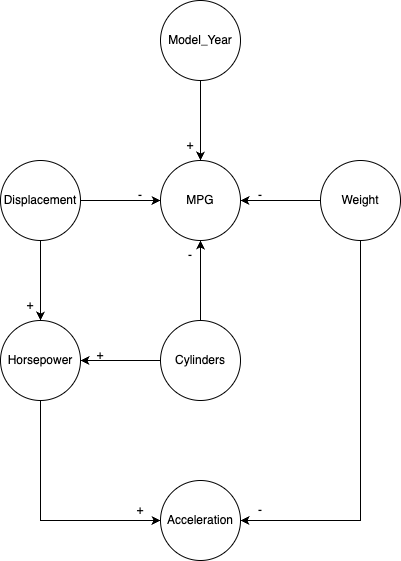

We hypothesize that Displacement, Weight and Cylinders will increase the MPG, while increasing Model_Year will decrease MPG. We predict that Displacement and Cylinders will both increase Horsepower, which will in turn increase Acceleration. We predict that Weight will also decrease Acceleration. This is our initial understanding of the causal loop represented by the data, and we will expand on our understanding as our EDA progresses.

In [5]:
def freeman_diaconis(data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int(np.ceil(h))

In [6]:
def histogram_w_whiskers(data, variable_name, zoom=None):
    h = freeman_diaconis(data[variable_name])
    mn = int(data[variable_name].min())
    mx = int(data[variable_name].max())
    bins = [i for i in range( mn, mx, h)]
    print(f"Freeman Diaconis for {variable_name}: {len(bins)} bins")

    observations = len(data)
    empirical_weights = np.ones(observations)/observations # this converts counts to relative frequencies when used in hist()
        
    # start the plot: 2 rows, because we want the boxplot on the first row
    # and the hist on the second
    fig, ax = plt.subplots(
        2, figsize=(7, 5), sharex=True,
        gridspec_kw={"height_ratios": (.7, .3)}  # the boxplot gets 30% of the vertical space
    )

    # the histogram
    ax[0].hist(data[variable_name],bins=bins, color="dimgray", weights=empirical_weights)
    ax[0].set_title(f"{variable_name} distribution - Freeman Diaconis")
    ax[0].set_ylabel("Relative Frequency")
    if zoom:
        ax[0].set_ylim((0, zoom))
    # the box plot
    ax[1].boxplot(data[variable_name], vert=False)
    # removing borders
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].set_xlabel(variable_name)

    # and we are good to go
    plt.show()
    plt.close()
    return h

In [7]:
def histogram_trio(data, variable_name, zoom=1.0):
    h = freeman_diaconis(data[variable_name])
    mn = int(data[variable_name].min())
    mx = int(data[variable_name].max())
    bins = [i for i in range( mn, mx, h)]
    print(f"Freeman Diaconis for {variable_name}: {len(bins)} bins")

    observations = len(data)
    empirical_weights = np.ones(observations)/observations # this converts counts to relative frequencies when used in hist()

    fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

    fewer_bins = int(len(bins) * .50)
    more_bins = int(len(bins) * 2)

    n, bins, patches = ax[1].hist(data[variable_name], color="DimGray", bins=bins, weights=empirical_weights) # <---
    ax[1].set_xlabel(variable_name)
    ax[1].set_ylabel("Relative Frequency")
    ax[1].set_title(f"Relative Frequency Histogram of {variable_name}")
    ax[1].set_ylim((0, zoom))
    
    n, bins, patches = ax[0].hist(data[variable_name], color="DimGray", bins=fewer_bins, weights=empirical_weights)
    ax[0].set_xlabel(variable_name)
    ax[0].set_ylabel("Relative Frequency")
    ax[0].set_title(f"Relative Frequency Histogram of {variable_name} (Fewer Bins)")
    
    n, bins, patches = ax[2].hist(data[variable_name], color="DimGray", bins=more_bins, weights=empirical_weights)
    ax[2].set_xlabel(variable_name)
    ax[2].set_ylabel("Relative Frequency")
    ax[2].set_title(f"Relative Frequency Histogram of {variable_name} (More Bins)")

    plt.show()
    plt.close()

In [8]:
def describe_by_category(data, numeric, categorical, transpose=False):
    grouped = data.groupby(categorical)
    grouped_y = grouped[numeric].describe()
    if transpose:
        print(grouped_y.transpose())
    else:
        print(grouped_y)

In [9]:
def lowess_scatter(data, x, y, jitter=0.0, skip_lowess=False):
    
    if skip_lowess:
        fit = np.polyfit(data[x], data[y], 1)
        line_x = np.linspace(data[x].min(), data[x].max(), 10)
        line = np.poly1d(fit)
        line_y = list(map(line, line_x))
    else:
        lowess = sm.nonparametric.lowess(data[y], data[x], frac=.3)
        line_x = list(zip(*lowess))[0]
        line_y = list(zip(*lowess))[1]
    
    figure = plt.figure(figsize=(10, 6))
    
    axes = figure.add_subplot(1, 1, 1)
    
    xs = data[x]
    if jitter > 0.0:
        xs = data[x] + stats.norm.rvs( 0, 0.5, data[x].size)
    
    axes.scatter(xs, data[y], marker="o", color="DimGray", alpha=0.5)
    axes.plot(line_x, line_y, color="DarkRed")
    
    title = "Plot of {0} v. {1}".format(x, y)
    if not skip_lowess:
        title += " with LOWESS"
    axes.set_title(title)
    axes.set_xlabel(x)
    axes.set_ylabel(y)
    
    plt.show()
    plt.close()

## 1.2 - EDA

Let's review the EDA from the previous notebook. What did we learn?

* Cylinders - Numerical variable, very strong negative correlation with MPG.
* Displacement - Numerical variable, strong negative correlation with MPG.
* Horsepower - Numerical variable, strong negative correlation with MPG.
* Weight - Numerical variable, strong negative correlation with MPG.
* Acceleration - Numerical variable, low positive correlation with MPG.
* Model_Year - Numerical variable, ordered. moderate positive correlation with MPG.
* Origin - Categorical variable. EDA indicates at least somewhat strong correlation with MPG.
* Car_Name - Categorical variable. Possible to have slight correlation with MPG, but unsure.
* MPG - Numerical variable, our target variable.


For the features, there's nothing that particularly stands out as needing our attention. Origin will need to be broken into dummy variables. Since Car_Name is unique for almost every data point, there is no need to include it in our model, so there is no need to break it into dummy variables.

<a id="Predictive Model"></a>
## Null Model

We want to be able to predict the MPG of a randomly selected car from this time period.

To create our predictive model, we first define our loss function. We intend for overestimates and underestimates to be treated symmetrically, and for large errors to be given more weight than small errors. Thus, we choose our loss function to be Mean Squared Error. Because we have chosen Mean Squared Error to be our loss function, and the constant model that will minimize MSE is the mean, we choose the mean as our constant model.

To create a mean model for our car data, we can take the mean value generated from our descriptive statistics above for the MPG variable. We can recalculate the mean as follows.

In [10]:
car_predict = np.mean(df.MPG)
print(car_predict)

23.445918367346938


We find that the mean MPG of our data is 23.4. As a predictive model, we can say that the MPG of a random car from the same time period will get about 23.4 mpg.

In order to provide error bounds on our prediction, we have two options. If the data is approximately normally distributed, we can put bounds on our error of 1.96 standard deviations from the mean. If they are not, we can use Chebyshev's inequality, which states that $1 - \frac{1}{k^2}$ percent of the data must be within $k$ standard deviations from the mean. 

Since the MPG data seems to be approximately normally distributed (not necessarily actually normally distributed), we will use 1.96 standard deviations from the mean as our error bounds. 

We recalculate the standard deviation of the data as follows.

In [11]:
car_std = np.std(df.MPG)
print(car_std)

7.795045762682583


We find that the standard deviation of our data is 7.79.

Now we can calculate our error bounds.

In [12]:
car_error = car_std * 1.96
print(car_error)

car_predict, car_predict - car_error, car_predict + car_error

15.278289694857863


(23.445918367346938, 8.167628672489075, 38.7242080622048)

Thus, we can say that our mean model predicts that a random car will get 23.4 mpg, with a 95% chance of it getting between 8.17 and 38.72 mpg.

## 1.3 - Build the linear model

* this is going to be the bulk of the code and discussion
* we are more interested in *process* than a particular RMSE, ie, are you doing the right things?

First, let's create our dummy variables for the Origin variable.

In [13]:
df = pd.concat([df, pd.get_dummies(df["Origin"], prefix="Origin")], axis=1)
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model_Year,Origin,Car_Name,Origin_1,Origin_2,Origin_3
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,"""chevrolet chevelle malibu""",1,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,"""buick skylark 320""",1,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,"""plymouth satellite""",1,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,"""amc rebel sst""",1,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,"""ford torino""",1,0,0


We see above that we have successfully added the three dummy variables, Origin_1, Origin_2 and Origin_3 to our dataframe.

Since we've decided to use a linear model, let's look at the correlation coefficients between the variables and the target variable.

In [14]:
def correlations(data, y, xs):
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})

In [15]:
correlations(df, "MPG", ["Cylinders", "Displacement", "Horsepower", "Weight", "Acceleration", "Model_Year", 
                           "Origin_1", "Origin_2", "Origin_3"])

,feature,r,rho
0,Cylinders,-0.777618,-0.823175
1,Displacement,-0.805127,-0.855234
2,Horsepower,-0.778427,-0.853616
3,Weight,-0.832244,-0.875585
4,Acceleration,0.423329,0.441539
5,Model_Year,0.580541,0.574841
6,Origin_1,-0.565161,-0.571642
7,Origin_2,0.244313,0.253350
8,Origin_3,0.451454,0.450745


There are some interesting results here:

1. Cylinders - As we expected, Cylinders has a strong negative correlation with MPG.
2. Displacement - As we expected, Displacement has a strong negative correlation with MPG.
3. Horsepower - As we expected, Horsepower has a strong negative correlation with MPG.
4. Weight - As we expected, Weight has a strong negative correlation with MPG.
5. Acceleration - As we expected, Acceleration has a low positive correlation with MPG.
6. Model_Year - As we expected, Model_Year has a moderate positive correlation with MPG.
7. Origin_1 - Because Origin_1 is a dummy variable, we didn't have a strong expectation of it's sign or magnitude.
8. Origin_2 - Because Origin_2 is a dummy variable, we didn't have a strong expectation of it's sign or magnitude.
9. Origin_3 - Because Origin_3 is a dummy variable, we didn't have a strong expectation of it's sign or magnitude.

Before estimating any linear models, let's look again at our Null model (the mean):

In [16]:
df.MPG.describe()

count    392.000000
mean      23.445918
std        7.805007
min        9.000000
25%       17.000000
50%       22.750000
75%       29.000000
max       46.600000
Name: MPG, dtype: float64

The lowest MPG is 9.0 and the highest is 46.6. The mean is 23.4 with a standard deviation of 7.8.

This is what we're trying to beat by creating a linear regression model.

The best place to start is the "all in" model. 

We have domain knowledge and some statistics to support the exclusion of some variables, such as Table, Depth, Cut, Color and Clarity, but we will leave them in for our first "all in" model anyway. Me make sure to remove one category from each categorical variable. In this case, we simply remove Origin_3 from the model.

The theory of feature bundles suggests that subtractive modeling (removing variables) is better than additive modeling (adding variables one at a time).

In [17]:
import models

In [18]:
model = "MPG ~ Cylinders + Displacement + Horsepower + Weight + Acceleration + Model_Year + Origin_1 + Origin_2"

result1 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result1)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-15.10,-23.66,-3.19
Cylinders,$\beta_{1}$,-0.49,-1.17,0.05
Displacement,$\beta_{2}$,0.02,0.01,0.04
Horsepower,$\beta_{3}$,-0.02,-0.05,0.01
Weight,$\beta_{4}$,-0.01,-0.01,-0.01
Acceleration,$\beta_{5}$,0.08,-0.20,0.28
Model_Year,$\beta_{6}$,0.78,0.66,0.87
Origin_1,$\beta_{7}$,-2.85,-3.99,-1.81
Origin_2,$\beta_{8}$,-0.22,-1.45,1.27


The coefficient of determination ($R^2$) is 82% which is good.
The error ($\sigma$) has been greatly reduced compared to the Null model, which had a $\sigma$ of 7.8. The $\sigma$ of the new model is just 3.31.

As for the signs of the variables, they are mostly what we would expect. Cylinders, Horsepower and Weight all have negative coefficients, which is what we expected. Acceleration and Model year both have positive coefficients, which we also expected. 

The coefficient that is not the sign we expected is for Displacement, which has a coefficient of 0.02. It is possible then that we should remove some variables. Perhaps there is multicollinearity in our model.

We know that Acceleration is heavily dependent on Weight and Horsepower, so let's try removing it from our model.

In [19]:
model = "MPG ~ Cylinders + Displacement + Horsepower + Weight + Model_Year + Origin_1 + Origin_2"

result1 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result1)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-13.47,-22.03,-5.78
Cylinders,$\beta_{1}$,-0.50,-1.04,0.20
Displacement,$\beta_{2}$,0.02,0.01,0.04
Horsepower,$\beta_{3}$,-0.03,-0.05,-0.00
Weight,$\beta_{4}$,-0.01,-0.01,-0.01
Model_Year,$\beta_{5}$,0.77,0.69,0.88
Origin_1,$\beta_{6}$,-2.86,-4.11,-1.99
Origin_2,$\beta_{7}$,-0.22,-1.55,1.07
,,,,


After removing the Acceleration variable, our R squared value has remained almost exactly the same at 0.82. Our error is also almost unchanged at 3.31, indicating that the Acceleration variable was not helping our model. 

We still notice that the Displacement coefficient is positive, when we expected it to be negative. Let's try removing it from the model.

In [20]:
model = "MPG ~ Cylinders + Horsepower + Weight + Model_Year + Origin_1 + Origin_2"

result2 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result2)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-15.26,-24.81,-8.10
Cylinders,$\beta_{1}$,0.14,-0.21,0.60
Horsepower,$\beta_{2}$,-0.01,-0.03,0.01
Weight,$\beta_{3}$,-0.01,-0.01,-0.01
Model_Year,$\beta_{4}$,0.76,0.65,0.87
Origin_1,$\beta_{5}$,-2.33,-3.26,-1.14
Origin_2,$\beta_{6}$,-0.29,-1.51,1.47
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,


We notice that the R squared remains almost the same, and the error increases slightly. More importantly, we notice that the Cylinders coefficient is now positive, which is not what we expect. Overall, it doesn't seem like removing Displacement has helped the prediction or explanatory nature of our model.

Let's put the Displacement variable back in the model.

In [21]:
model = "MPG ~ Cylinders + Displacement + Horsepower + Weight + Model_Year + Origin_1 + Origin_2"

result3 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result3)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-13.47,-20.49,-5.98
Cylinders,$\beta_{1}$,-0.50,-0.99,0.19
Displacement,$\beta_{2}$,0.02,0.01,0.04
Horsepower,$\beta_{3}$,-0.03,-0.05,-0.00
Weight,$\beta_{4}$,-0.01,-0.01,-0.01
Model_Year,$\beta_{5}$,0.77,0.68,0.86
Origin_1,$\beta_{6}$,-2.86,-3.81,-1.78
Origin_2,$\beta_{7}$,-0.22,-1.80,0.95
,,,,


Let's look for patterns in the residuals.

In [22]:
def plot_residuals(result, variables):
    figure = plt.figure(figsize=(20,6))
    


    plots = len( variables)
    rows = (plots // 3) + 1

    residuals = np.array([r[0] for r in result["residuals"]])
    limits = max(np.abs(residuals.min()), residuals.max())
    
    n = result["n"]
    for i, variable in enumerate( variables):
        axes = figure.add_subplot(rows, 3, i + 1)

        keyed_values = sorted(zip(df[variable].values, residuals), key=lambda x: x[ 0])
        ordered_residuals = [x[ 1] for x in keyed_values]

        axes.plot(list(range(0, n)), ordered_residuals, '.', color="dimgray", alpha=0.75)
        axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
        axes.set_ylim((-limits, limits))
        axes.set_ylabel("residuals")
        axes.set_xlabel(variable)
        
    plt.subplots_adjust(hspace=0.4)
    plt.show()
    plt.close()
    
    return residuals

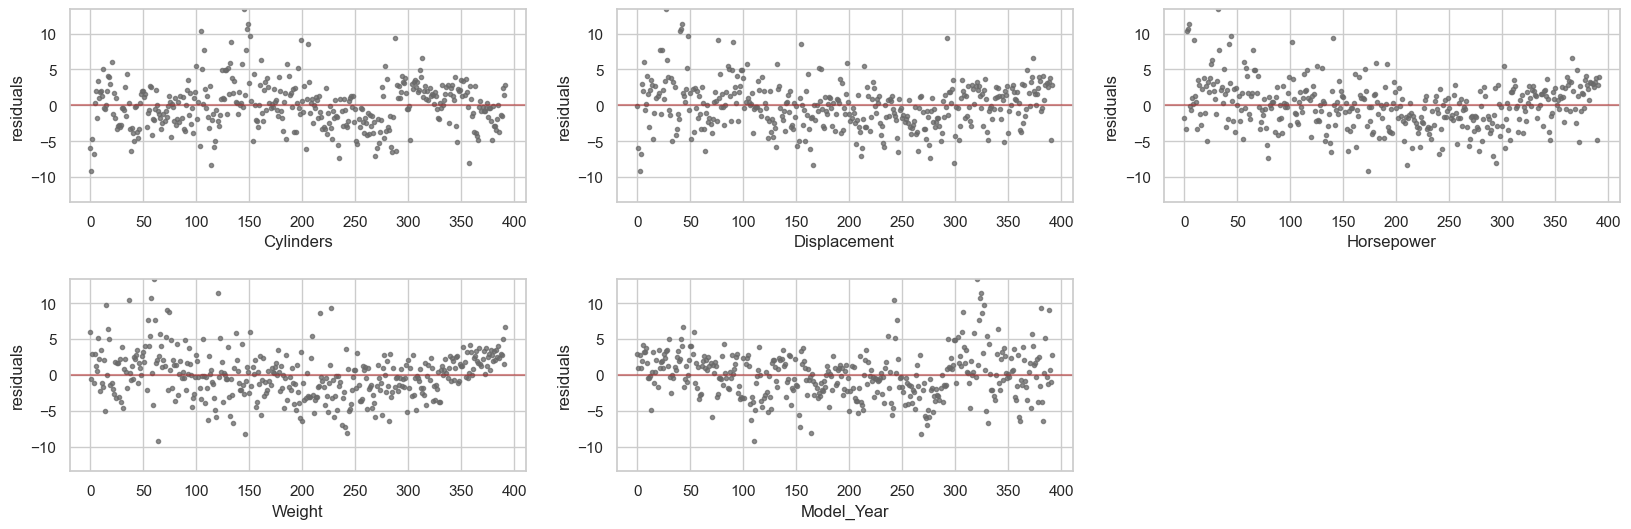

In [23]:
residuals3 = plot_residuals(result3, ["Cylinders", "Displacement", "Horsepower", "Weight", "Model_Year"])

We observe some curvature in the residuals for Displacement, Horsepower and Weight. There is possibly some curvature for Model_Year as well but it is somewhat less pronounced. 

The curvature suggests we may want to square these variables. Let's try squaring Displacement and seeing what happens.

In [24]:
df["Displacement_sq"] = df.Displacement**2

In [25]:
model = "MPG ~ Cylinders + Displacement_sq + Horsepower + Weight + Model_Year + Origin_1 + Origin_2"

result4 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result4)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-10.55,-19.02,-3.47
Cylinders,$\beta_{1}$,-0.64,-1.11,-0.29
Displacement_sq,$\beta_{2}$,0.00,0.00,0.00
Horsepower,$\beta_{3}$,-0.05,-0.07,-0.03
Weight,$\beta_{4}$,-0.01,-0.01,-0.01
Model_Year,$\beta_{5}$,0.79,0.70,0.88
Origin_1,$\beta_{6}$,-2.61,-3.68,-1.65
Origin_2,$\beta_{7}$,-0.14,-1.46,0.90
,,,,


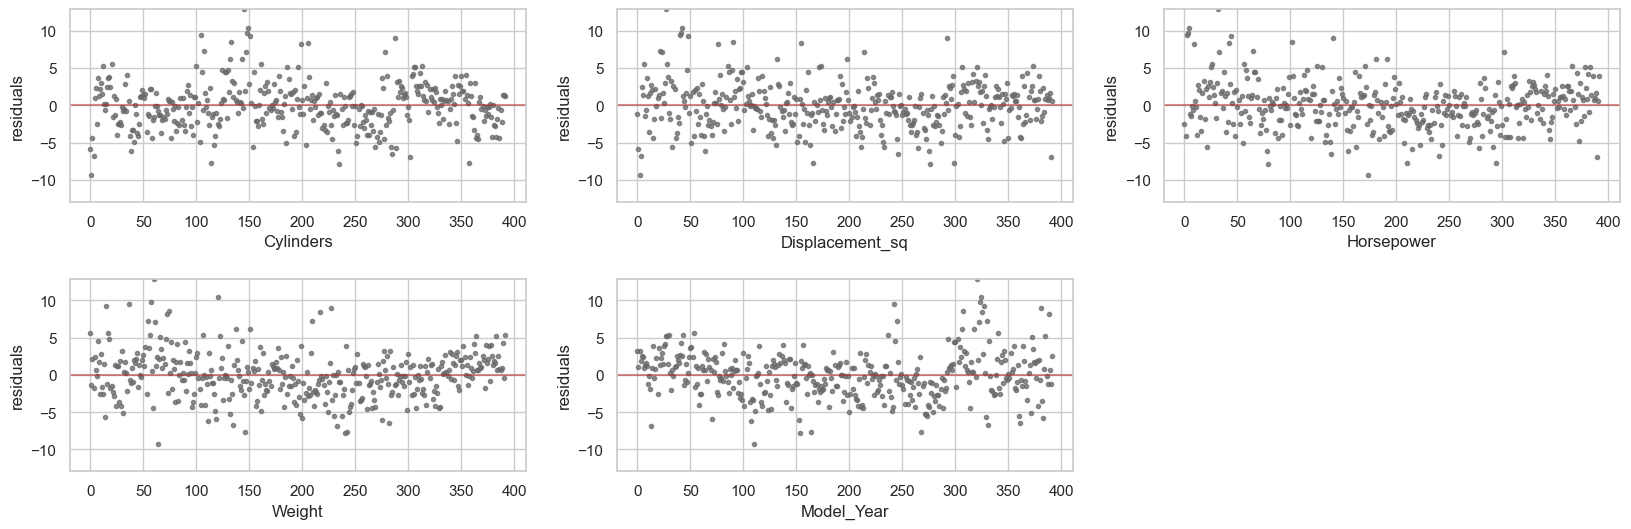

In [26]:
residuals4 = plot_residuals(result4, ["Cylinders", "Displacement_sq", "Horsepower", "Weight", "Model_Year"])

Interestingly, we notice a jump in our R squared from 0.82 to 0.84, and a decrease in our error from 3.31 to 3.17. We also notice the curvature is mostly gone from our Displacement variable, and some of the curvature is also gone from the Horsepower and Weight variables. It seems as though squaring the Displacement variable helped our model. 

Now let's try the same for Horsepower, since we noticed curvature in the Horsepower residuals as well.

In [27]:
df["Horsepower_sq"] = df.Horsepower**2
# df["Weight_sq"] = df.Weight**2

In [28]:
model = "MPG ~ Cylinders + Displacement_sq + Horsepower_sq + Weight + Model_Year + Origin_1 + Origin_2"

result5 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result5)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-14.37,-22.68,-7.47
Cylinders,$\beta_{1}$,-0.69,-1.17,-0.18
Displacement_sq,$\beta_{2}$,0.00,0.00,0.00
Horsepower_sq,$\beta_{3}$,-0.00,-0.00,0.00
Weight,$\beta_{4}$,-0.01,-0.01,-0.01
Model_Year,$\beta_{5}$,0.81,0.72,0.92
Origin_1,$\beta_{6}$,-2.41,-3.59,-1.77
Origin_2,$\beta_{7}$,0.03,-1.59,1.19
,,,,


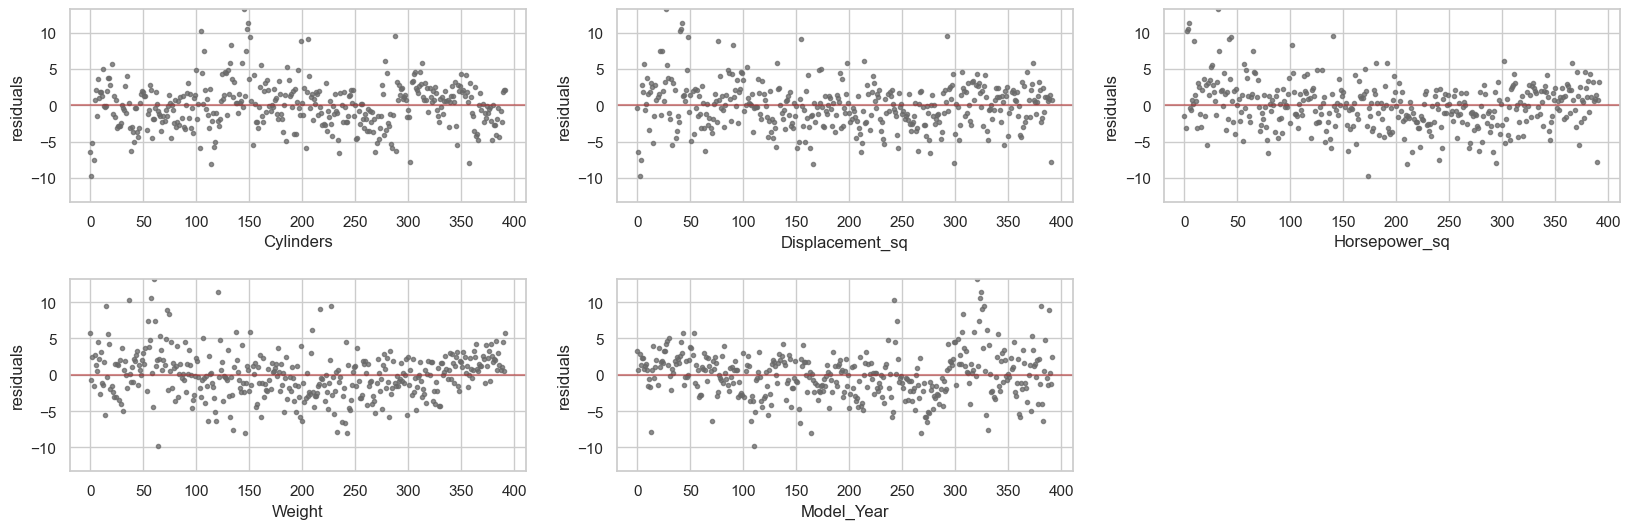

In [29]:
residuals5 = plot_residuals(result5, ["Cylinders", "Displacement_sq", "Horsepower_sq", "Weight", "Model_Year"])

Oddly, we observe our R squared decrease from 0.84 to 0.83, and our error increase from 3.17 to 3.23. The curvature in the Horsepower and Weight variables is still visible. 

Let's instead try squaring Weight.

In [30]:
df["Weight_sq"] = df.Weight**2

In [31]:
model = "MPG ~ Cylinders + Displacement_sq + Horsepower + Weight_sq + Model_Year + Origin_1 + Origin_2"

result6 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result6)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-14.85,-23.64,-5.29
Cylinders,$\beta_{1}$,-1.13,-1.52,-0.72
Displacement_sq,$\beta_{2}$,0.00,0.00,0.00
Horsepower,$\beta_{3}$,-0.06,-0.10,-0.03
Weight_sq,$\beta_{4}$,-0.00,-0.00,-0.00
Model_Year,$\beta_{5}$,0.75,0.63,0.86
Origin_1,$\beta_{6}$,-3.46,-4.45,-2.45
Origin_2,$\beta_{7}$,-0.65,-1.89,0.63
,,,,


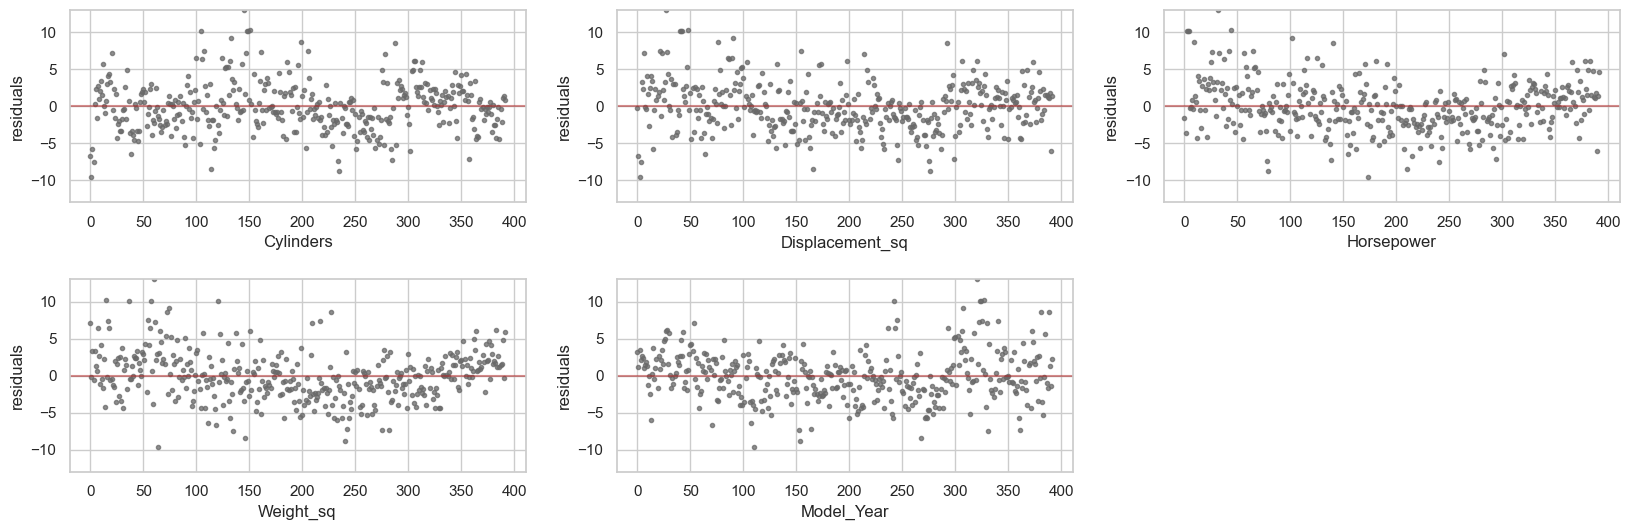

In [32]:
residuals6 = plot_residuals(result6, ["Cylinders", "Displacement_sq", "Horsepower", "Weight_sq", "Model_Year"])

Oddly, our R squared has dropped even further with the Weight_sq variable down to 0.81, and our error has increased to 3.39.

Let's try a model with squaring only Horsepower and not Displacement.

In [33]:
model = "MPG ~ Cylinders + Displacement + Horsepower_sq + Weight + Model_Year + Origin_1 + Origin_2"

result7 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result7)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-16.73,-24.70,-8.73
Cylinders,$\beta_{1}$,-0.38,-1.01,0.26
Displacement,$\beta_{2}$,0.01,-0.00,0.03
Horsepower_sq,$\beta_{3}$,0.00,-0.00,0.00
Weight,$\beta_{4}$,-0.01,-0.01,-0.01
Model_Year,$\beta_{5}$,0.80,0.70,0.90
Origin_1,$\beta_{6}$,-2.38,-3.59,-1.38
Origin_2,$\beta_{7}$,-0.06,-1.27,1.38
,,,,


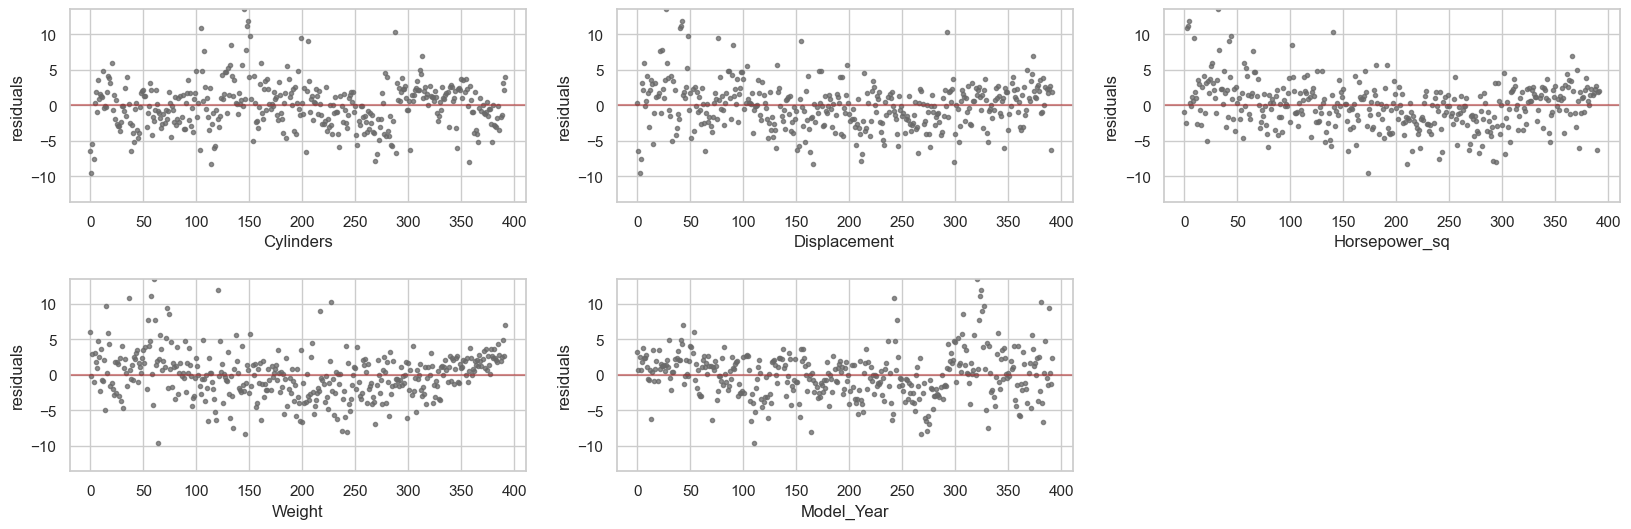

In [34]:
residuals7 = plot_residuals(result7, ["Cylinders", "Displacement", "Horsepower_sq", "Weight", "Model_Year"])

The R squared has not benefitted and we see the curvature return to Displacement. It seems that Squaring Displacement helped after all.

Let's go back to changing the Displacement term, but let's try cubing it instead of squaring it, since displacement is a volume and volume is a cubic measurement.

In [35]:
df["Displacement_cubed"] = df.Displacement**3

In [36]:
model = "MPG ~ Cylinders + Displacement_cubed + Horsepower + Weight + Model_Year + Origin_1 + Origin_2"

result8 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result8)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-11.10,-18.43,-4.29
Cylinders,$\beta_{1}$,-0.30,-0.72,0.13
Displacement_cubed,$\beta_{2}$,0.00,0.00,0.00
Horsepower,$\beta_{3}$,-0.06,-0.08,-0.03
Weight,$\beta_{4}$,-0.01,-0.01,-0.00
Model_Year,$\beta_{5}$,0.78,0.68,0.86
Origin_1,$\beta_{6}$,-2.32,-3.42,-1.26
Origin_2,$\beta_{7}$,-0.17,-1.33,0.98
,,,,


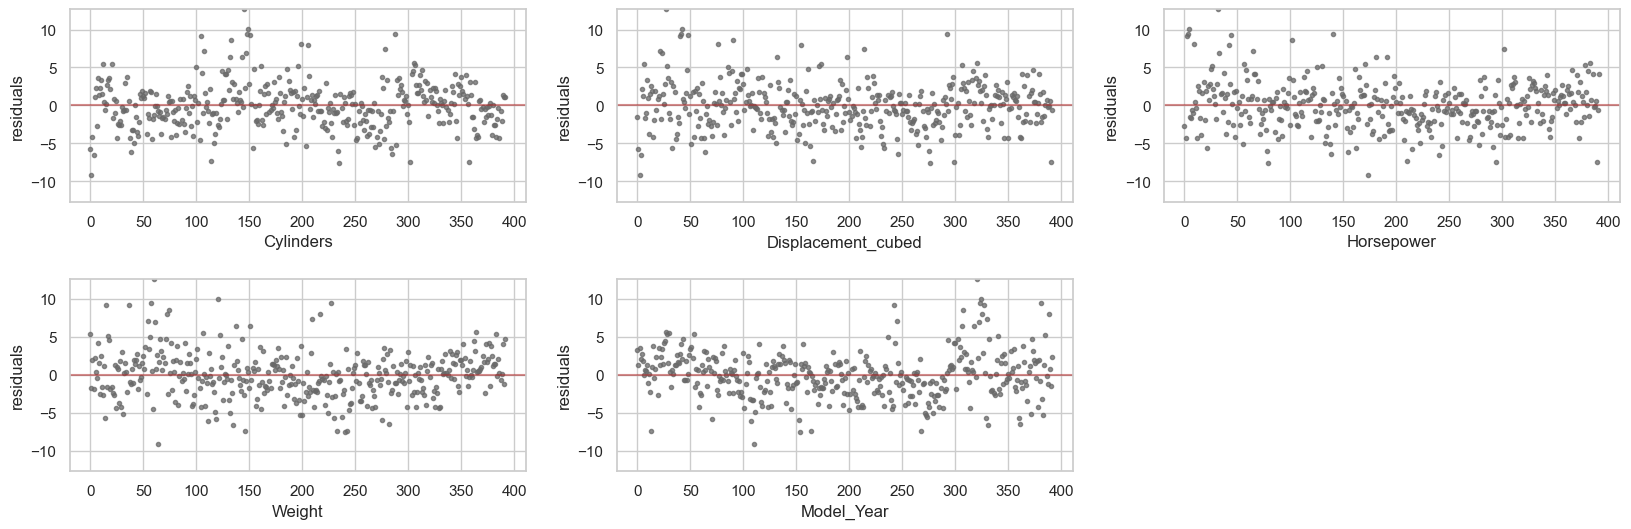

In [37]:
residuals8 = plot_residuals(result8, ["Cylinders", "Displacement_cubed", "Horsepower", "Weight", "Model_Year"])

We notice our R squared jump back up to 0.84, as we expected, but we also see our error decrease again to 3.11, which is a new low. The residuals for Displacement_cubed are also less curved than for Displacement_sq. 

Let's see the residuals for Displacement_sq again to compare.

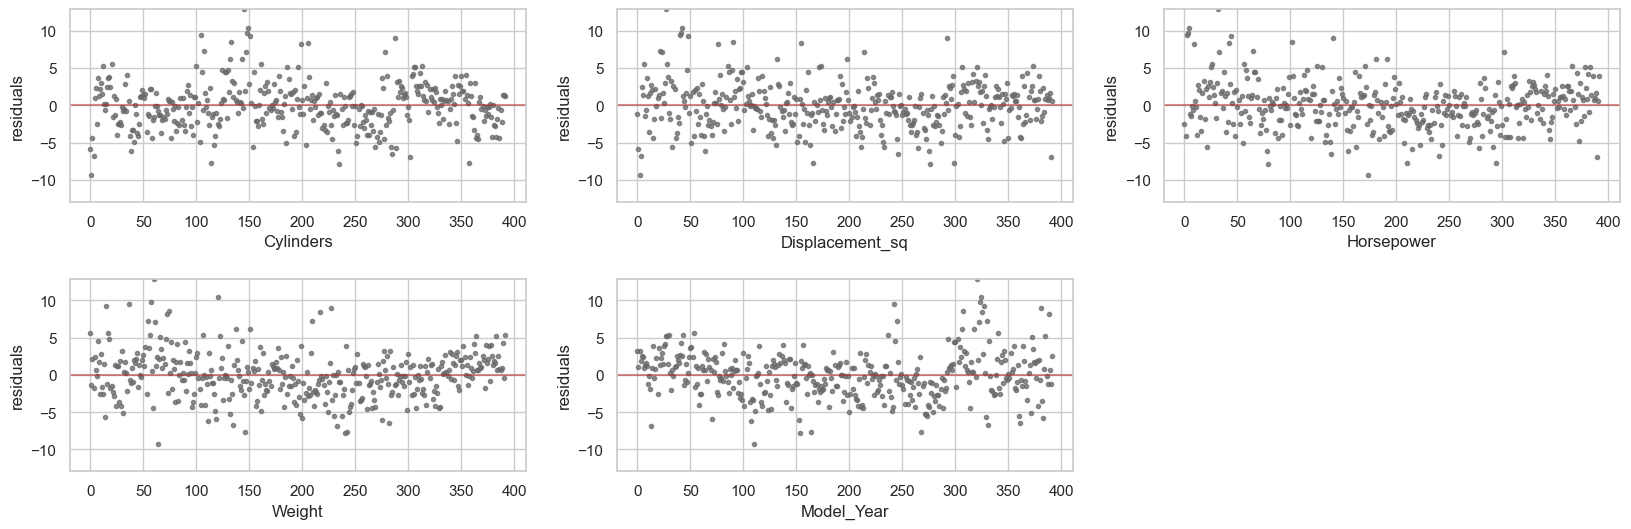

In [38]:
residuals4 = plot_residuals(result4, ["Cylinders", "Displacement_sq", "Horsepower", "Weight", "Model_Year"])

We do notice that Displacement_cubed is closer to the 0 line than the Displacement_sq variable. It seems like cubing the Displacement term is better than squaring it.

We still see some curvature in the Horsepower and Weight variables. We know that Horsepower and Weight determine the acceleration of the car. Let's try an interaction term.

In [39]:
model = "MPG ~ Cylinders + Displacement_cubed + Horsepower + Weight + Horsepower:Weight + Model_Year + Origin_1 + Origin_2"

result9 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result9)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,0.08,-8.63,6.08
Cylinders,$\beta_{1}$,0.08,-0.25,0.39
Displacement_cubed,$\beta_{2}$,0.00,0.00,0.00
Horsepower,$\beta_{3}$,-0.20,-0.25,-0.15
Weight,$\beta_{4}$,-0.01,-0.01,-0.01
Horsepower:Weight,$\beta_{5}$,0.00,0.00,0.00
Model_Year,$\beta_{6}$,0.79,0.73,0.90
Origin_1,$\beta_{7}$,-1.58,-2.62,-0.73
Origin_2,$\beta_{8}$,-0.00,-1.31,1.12


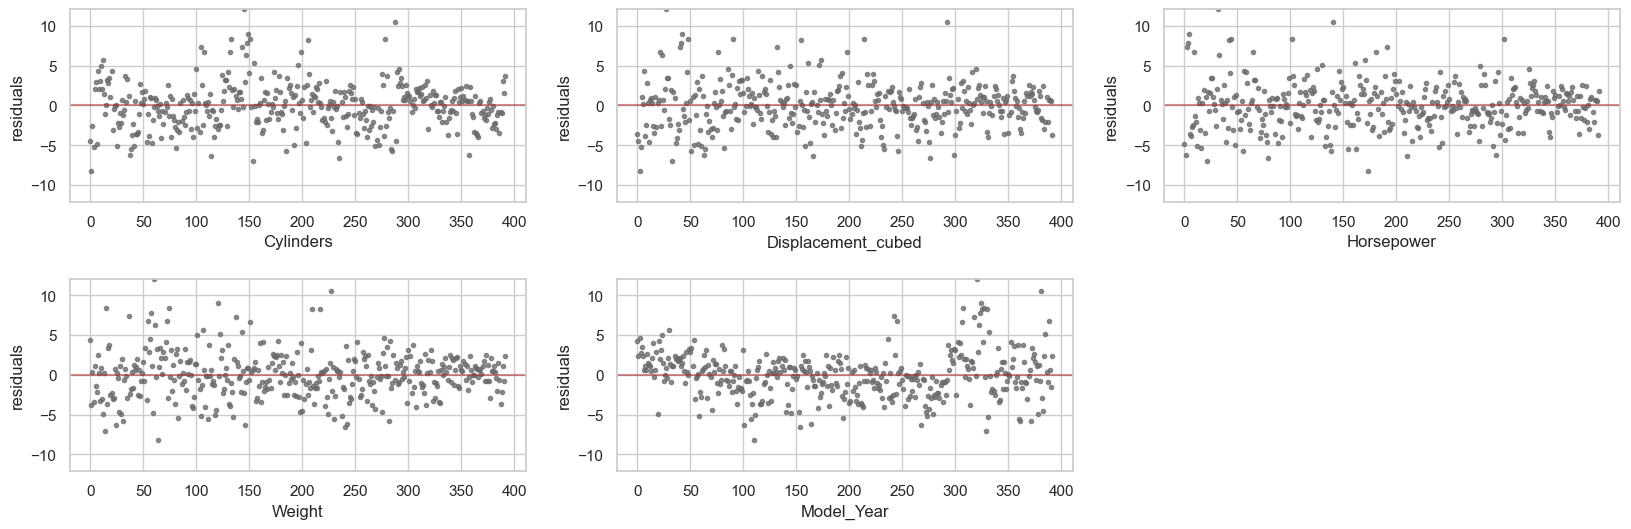

In [40]:
residuals9 = plot_residuals(result9, ["Cylinders", "Displacement_cubed", "Horsepower", "Weight", "Model_Year"])

Immediately we notice the curvature for the Weight and Horsepower variables is almost completely gone. We also see our R squared jump up from 0.84 to 0.86, and we see our error drop from 3.11 to 2.91. It seems like the interaction term has significantly improved our model. 

Let's check the adjusted $R^2$ values from our previous model and our current model.

In [41]:
print(models.adjusted_r_squared(result8))
print(models.adjusted_r_squared(result9))

0.8400210472603099
0.8604682288127503


Let's also check the adjusted $R^2$ values from our very first "all-in" model and our current model.

In [42]:
print(models.adjusted_r_squared(result1))
print(models.adjusted_r_squared(result9))

0.8197528290505777
0.8604682288127503


We observe increases across both increments.

We still can see some slight curvature in the Model_Year residuals. Let's try squaring this variable as well.

In [43]:
df["Model_Year_sq"] = df.Model_Year**2

In [44]:
model = "MPG ~ Cylinders + Displacement_cubed + Horsepower + Weight + Horsepower:Weight + Model_Year_sq + Origin_1 + Origin_2"

result10 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result10)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,29.72,24.91,35.07
Cylinders,$\beta_{1}$,0.09,-0.25,0.52
Displacement_cubed,$\beta_{2}$,0.00,0.00,0.00
Horsepower,$\beta_{3}$,-0.20,-0.26,-0.16
Weight,$\beta_{4}$,-0.01,-0.01,-0.01
Horsepower:Weight,$\beta_{5}$,0.00,0.00,0.00
Model_Year_sq,$\beta_{6}$,0.01,0.00,0.01
Origin_1,$\beta_{7}$,-1.59,-2.69,-0.68
Origin_2,$\beta_{8}$,0.02,-0.97,0.95


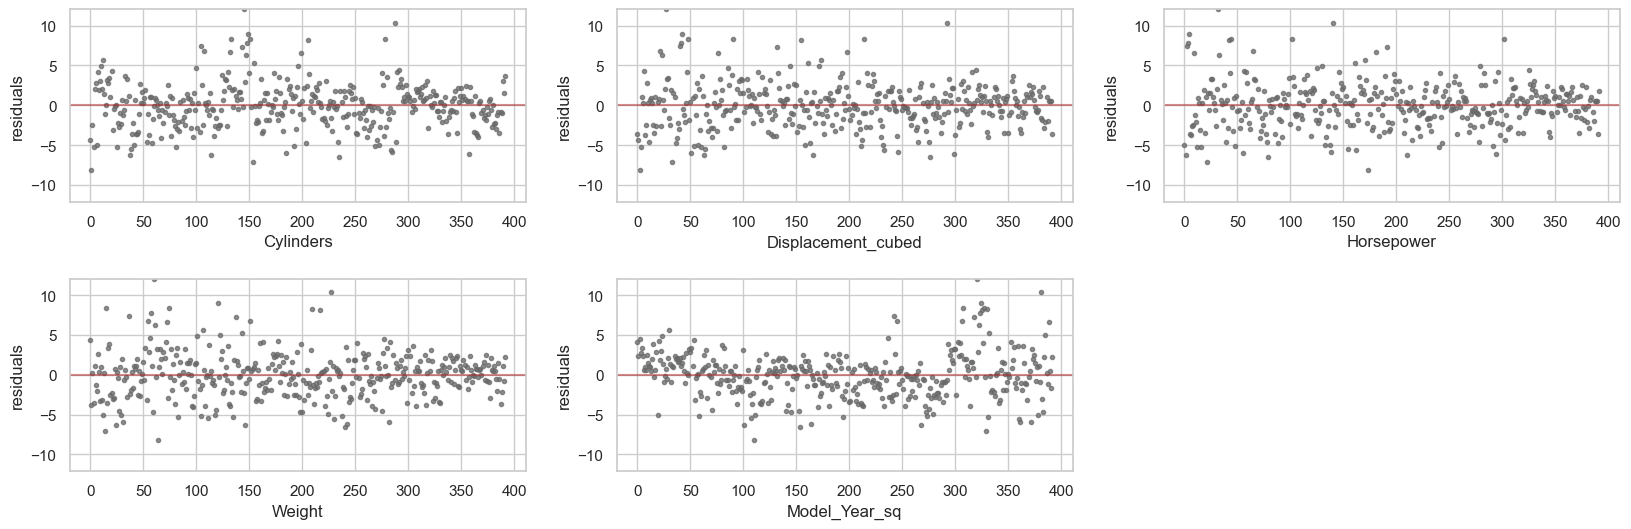

In [45]:
residuals10 = plot_residuals(result10, ["Cylinders", "Displacement_cubed", "Horsepower", "Weight", "Model_Year_sq"])

We observe our R squared go up from 0.86 to 0.87 and our error drop from 2.91 to 2.89. However, we barely notice a difference in the residuals between Model_Year_sq and Model_Year. Here are the earlier residuals for comparison.

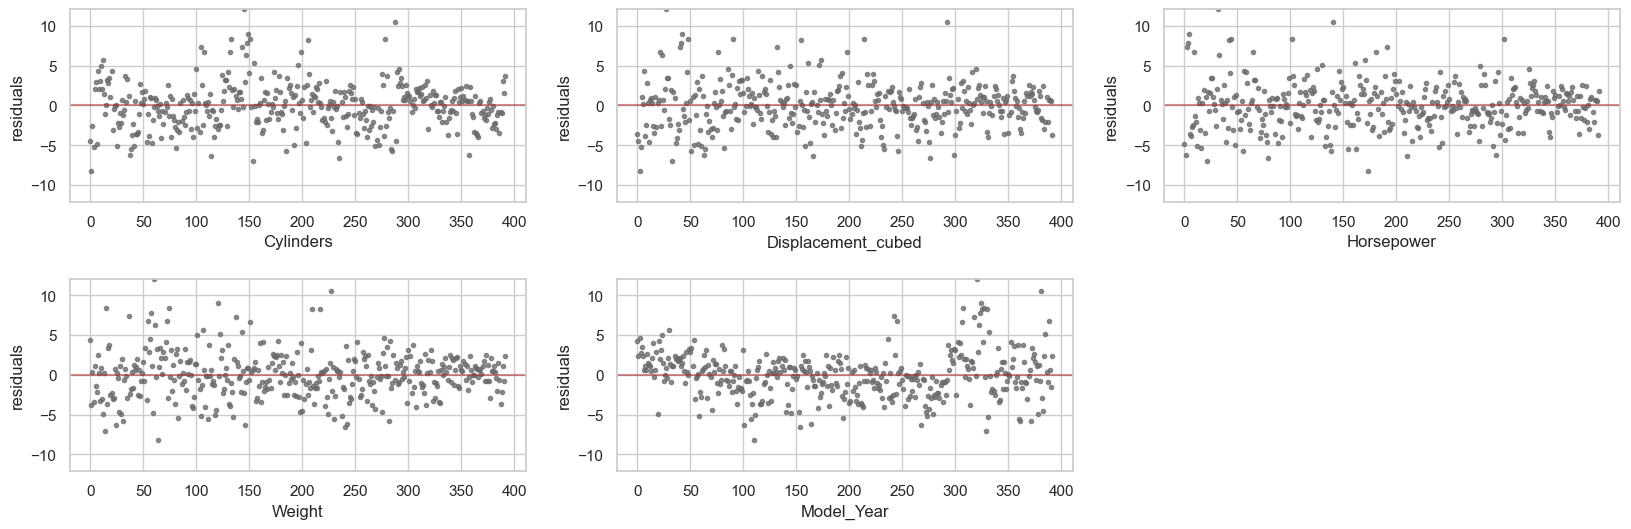

In [46]:
residuals9 = plot_residuals(result9, ["Cylinders", "Displacement_cubed", "Horsepower", "Weight", "Model_Year"])

The curvature did not go away, but squaring the Model_Year variable did increase our R squared and decrease our error, so we will keep it in.

Our model is looking good, but we notice the coefficient for Cylinders is positive, when we expected it to be negative. Let's try removing the Cylinders variable altogether.

In [47]:
model = "MPG ~ Displacement_cubed + Horsepower + Weight + Horsepower:Weight + Model_Year_sq + Origin_1 + Origin_2"

result11 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result11)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,29.76,24.37,35.21
Displacement_cubed,$\beta_{1}$,0.00,0.00,0.00
Horsepower,$\beta_{2}$,-0.20,-0.25,-0.16
Weight,$\beta_{3}$,-0.01,-0.01,-0.01
Horsepower:Weight,$\beta_{4}$,0.00,0.00,0.00
Model_Year_sq,$\beta_{5}$,0.01,0.00,0.01
Origin_1,$\beta_{6}$,-1.57,-2.75,-0.61
Origin_2,$\beta_{7}$,-0.00,-1.22,1.05
,,,,


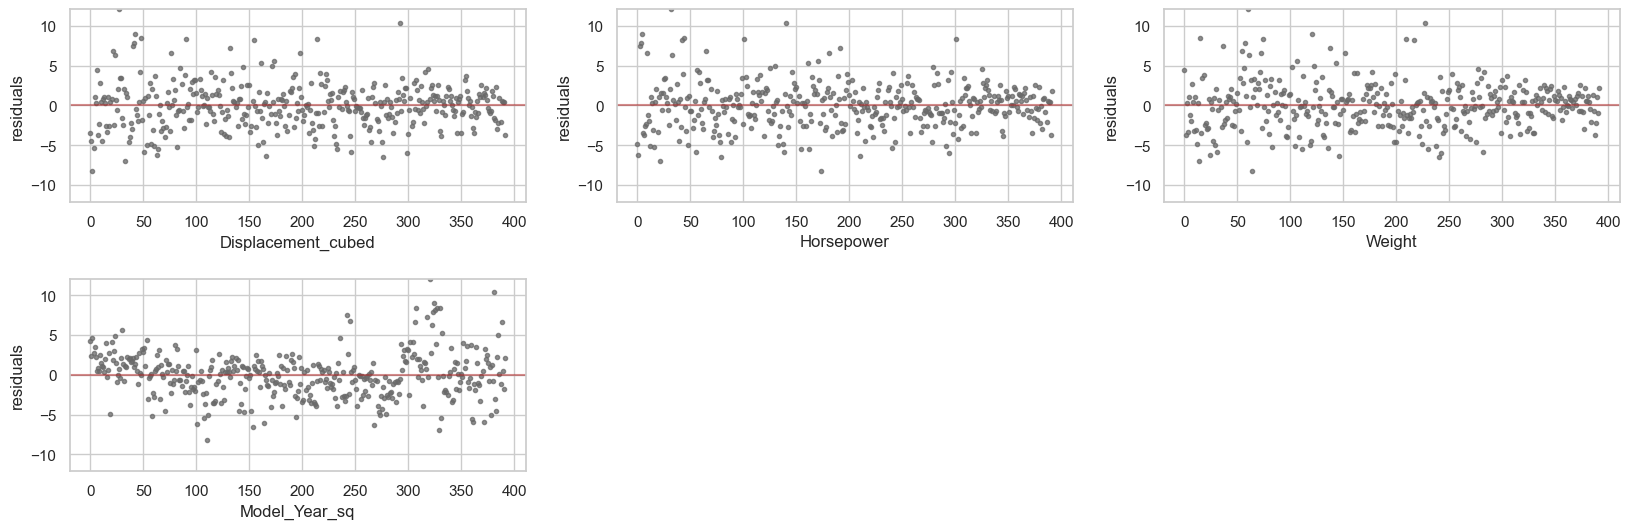

In [48]:
residuals11 = plot_residuals(result11, ["Displacement_cubed", "Horsepower", "Weight", "Model_Year_sq"])

Interestingly, we notice no change to our R squared or our error. The residuals plots also appear the same as before. It seems as though the Cylinders variable was not helping our model. Intuitively this makes sense, as most of the information in the Cylinders variable is already encapsulated in the Horsepower and Displacement_cubed variables. Now, all of our coefficients make intuitive sense.

Thus, our final model is as follows.

In [49]:
models.describe_bootstrap_lr(result11)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,29.76,24.37,35.21
Displacement_cubed,$\beta_{1}$,0.00,0.00,0.00
Horsepower,$\beta_{2}$,-0.20,-0.25,-0.16
Weight,$\beta_{3}$,-0.01,-0.01,-0.01
Horsepower:Weight,$\beta_{4}$,0.00,0.00,0.00
Model_Year_sq,$\beta_{5}$,0.01,0.00,0.01
Origin_1,$\beta_{6}$,-1.57,-2.75,-0.61
Origin_2,$\beta_{7}$,-0.00,-1.22,1.05
,,,,


We are happy with the R squared, the error and the residuals of our final model.

## 1.4 - Describe the final model

After creating our linear regression model, we are left with the variables Cylinders, Displacement_cubed, Horsepower, Weight, Horsepower:Weight, Model_Year_sq, Origin_1, and Origin_2. If we were to interpret the coefficients, we get the following. 

* Displacement_cubed - every unit of cubed displacement adds 0.0 to MPG.
* Horsepower - every horsepower subtracts 0.20 from MPG.
* Weight - every pound subtracts 0.01 from MPG.
* Horsepower:Weight - every Horsepower:Weight unit adds 0.0 to MPG.
* Model_Year_sq - every squared model year adds 0.01 to MPG.
* If the car is from Origin_1, subtract 1.57 from MPG.
* If the car is from Origin_2, subtract 0.0 from MPG.

Our final model has an R squared value of 0.87, meaning that it describes 87% of the variance in the data. It also has an error of 2.89. 

## 1.5 - Use the model

Now that we have built our model, we want to use it for prediction. In other words, we want to predict the MPG of a car with given attributes.

Suppose we have a car with a displacement of 307, 130 horsepower, 3504 pounds, from 1970, and is from Origin 1.

### Null Model Prediction

If we just look at the Null model, we have an estimated MPG of:

In [50]:
df.MPG.mean()

23.445918367346938

with an error of:

In [51]:
df.MPG.std()

7.805007486571798

We can use the 95% errors bounds for our prediction to get error bounds.

In [52]:
np.percentile(df.MPG, [2.5, 97.5])

array([12.    , 39.0225])

Our predicted MPG, based on the Null model, is 23.4 with 95% error bounds of 12 to 39.

### Linear Regression Prediction

Let's see how our linear regression model does.
Let's make a feature vector for our car.

In [53]:
car1 = [1.0, 307**3, 130, 3504, 130*3504, 70**2, 1, 0]

When defining the feature vector, we need to supply the intercept ($x_0$).
We also need to calculate the interaction terms and perform the transformations manually.

Looking at our residuals, we see that they are not symmetric so using the usual plus or minus 1.96 is a bit dodgey.
Instead we'll need to use the Bootstrap get a distribution of predictions.

1. generate Bootstrap sample
2. fit a new model
3. calculate residuals
4. make initial prediction
5. sample 1 residual
6. add residual to initial prediction
7. repeat
8. calculate 95% bounds of prediction

In [54]:
import random

In [55]:
model = "MPG ~ Displacement_cubed + Horsepower + Weight + Horsepower:Weight + Model_Year_sq + Origin_1 + Origin_2"
predictions = []
for i in range(100):
    bootstrap = df.sample(len(df), replace=True, random_state=342234)
    result = models.bootstrap_linear_regression(model, data=df)
    predict = result["model"].predict([car1])[0][0]
    error = random.choice(result["residuals"])[0]
    obs = predict + error
    predictions.append(obs)

Based on our final model, we can predict the following MPG for our sample car.

In [56]:
result["model"].predict([car1])[0][0]

13.779994324050644

Our linear regression model predicts an MPG of 13.7 for the car.

The distribution of predictions based on the Bootstrap is as follows.

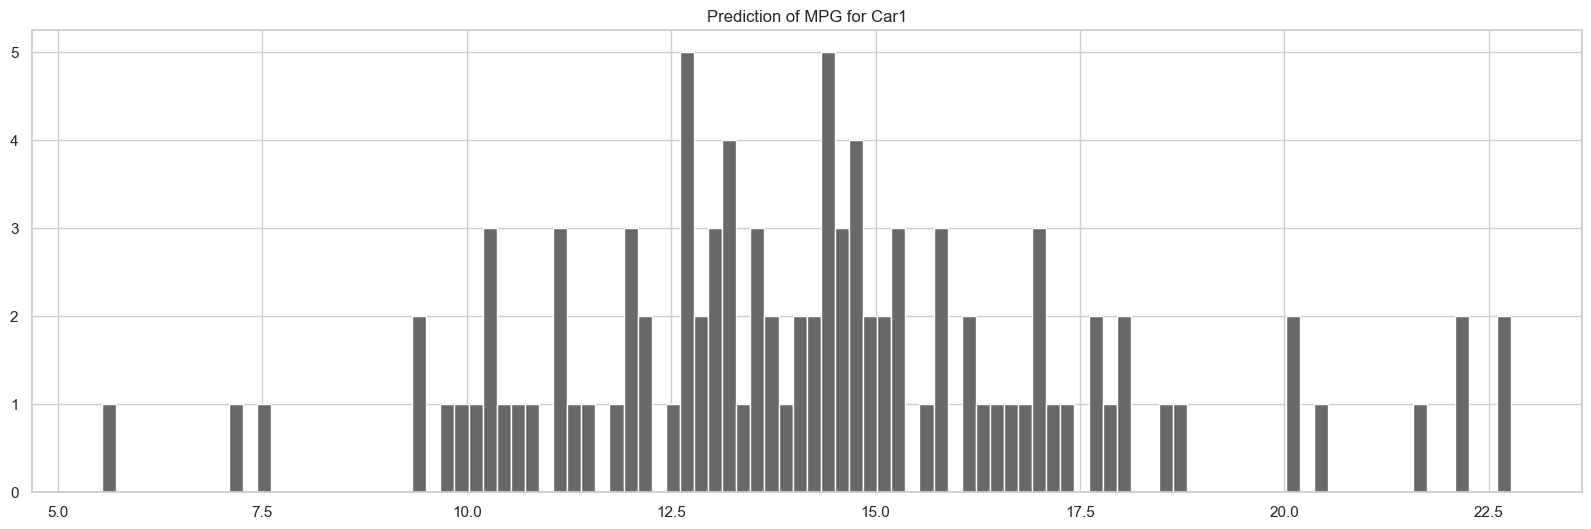

In [57]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1,1,1)
axes.hist(predictions, bins=100, color='dimgray')
axes.set_title("Prediction of MPG for Car1")
plt.show()
plt.close();

The 95% error bounds of the prediction is:

In [58]:
np.percentile(predictions, [2.5, 97.5])

array([ 8.48159699, 22.11813684])

The prediction range is thus 7.66 to 20.79.
This prediction range is much narrower than the original, Null model prediction range of 12 to 39 (95%).